# Определение токсичности правок пользователей

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача пректа:**

* на основе набора данных с разметкой о токсичности правок обучить модель классифицировать комментарии на позитивные и негативные.
* Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

* Данные находятся в файле `toxic_comments.csv`.
* Столбец *text* содержит текст комментария.
* Столбец *toxic* содержит целевой признак.

## Подготовка

### Загрузка данных

In [1]:
# подготавливаем рабочее пространство,
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud
from sklearn.utils import shuffle

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import notebook

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# загружаем и выводим данные
data = pd.read_csv(r'C:/Users/VB/toxic_comments.csv')
display(data.head(5))
display(data.info())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [3]:
# проверяем распределение данных признака Unnamed: 0 на монотонность,
# выводим стат данные
display(data['Unnamed: 0'].is_monotonic)
display(data['Unnamed: 0'].describe())

True

count    159292.000000
mean      79725.697242
std       46028.837471
min           0.000000
25%       39872.750000
50%       79721.500000
75%      119573.250000
max      159450.000000
Name: Unnamed: 0, dtype: float64

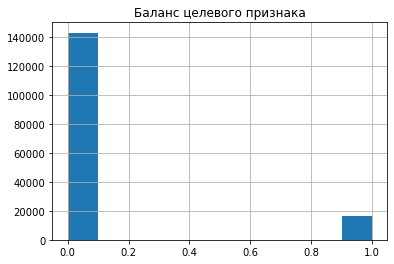

In [4]:
# проверяем баланс целевой переменной
data['toxic'].hist()
plt.title('Баланс целевого признака');

In [5]:
# проверяем датасет на пропуски
print('Ко-во пропусков:\n', data.isna().sum())

Ко-во пропусков:
 Unnamed: 0    0
text          0
toxic         0
dtype: int64


In [6]:
# проверяем датасет на дубликаты
print('Кол-во дубликатов:', data.duplicated().sum())

Кол-во дубликатов: 0


**Выводы по данным и графику:**
* исходный датасет содержит 159 292 записи и 3 колонки
* датасет не содержит пропусков
* датасет не содержит дубликатов
* колонка 'Unnamed: 0' представляет собой монотонный порядок чисел от 0 до 159 450, фактически повторяющих индекс; можно предположить, что эта колонка была индексом до обработки; принято решение ее удалить
* тексты приведены на английском языке
* в текстах использованы как нижний, так и верхний регистры; принято решение привести тексты к нижнему регистру
* в качестве подготовки текстов принято решение провести очистку, токенизацию и лемматизацию
* баланс целевого признака соотносится как 9 к 1 (90% записей с позитивной коннотацией, 10% записей с токсичной)
* для повышения качества обучения, чтобы модель имела больше шансов корректно определять 1, миноритарный класс, принято решение применить upsampling к обучающей выборке

In [7]:
# удаляем колонку 'Unnamed: 0'
data = data.drop('Unnamed: 0', axis=1)
data.shape

(159292, 2)

In [8]:
# приводим тексты к нижнему регистру
data['text'] = data['text'].apply(lambda x: x.lower())

In [9]:
# создаем функцию обработки текстов
stop_words = stopwords.words('english')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()
 
def data_preprocessing(text):
    
    # очистка
    text =  re.sub('[^A-Za-z0-9]+', ' ', text) # оставляем только слова
    # токенизация
    tokens = nltk.word_tokenize(text) # конвертируем тексты в токены
    # очистка от стоп слов
    text = [word for word in tokens if word not in stop_words] # убираем стоп слова
    # лемматизация
    text = [lemmatizer.lemmatize(word) for word in text]
    # объединяем слова в обработанных текстах
    text = ' '.join(text)
    
    return text

In [10]:
# производим очистку
data['text'] = data['text'].apply(lambda text: data_preprocessing(text))

In [11]:
# выводим данные и информацию
display(data.head())
display(data.shape)

,text,toxic
0,explanation edits made username hardcore metal...,0
1,aww match background colour seemingly stuck th...,0
2,hey man really not trying edit war guy constan...,0
3,make real suggestion improvement wondered sect...,0
4,sir hero chance remember page,0


(159292, 2)

In [12]:
# подсчитываем кол-во слов в текстах
word_counts = data['text'].apply(lambda x: len(x.split()))
word_counts.describe()

count    159292.000000
mean         36.409857
std          56.341444
min           0.000000
25%           9.000000
50%          19.000000
75%          40.000000
max        1250.000000
Name: text, dtype: float64

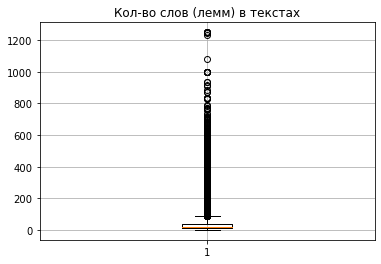

In [13]:
# строим диаграмму размаха,
# визуализируем распределение данных
plt.boxplot(word_counts.values)
plt.grid(True)
plt.title('Кол-во слов (лемм) в текстах');

**Выводы по данным и графику:**
* в среднем один текст содержит 36 слов (лемм)
* 25% текстов очень короткие и содержат до 9 слов (лемм)
* половина текстов содержат до 19 слов
* 75% текстов содержат до 40 слов
* имеются выбросы, максимальное кол-во слов в тексте = 1 250

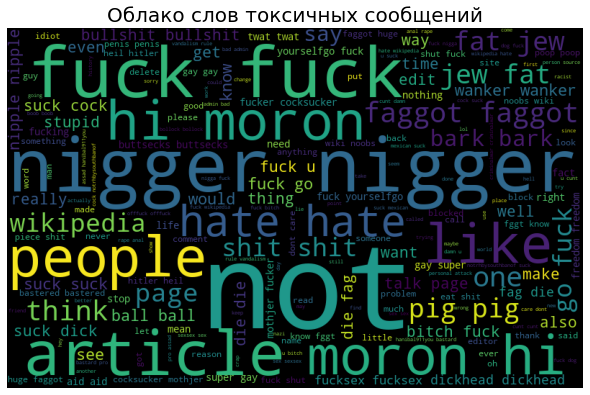

In [14]:
# визуализируем облако слов в текстах с токсичной коннотацией 
words_list = data[data['toxic']==1]['text'].unique().tolist()
pos_words = " ".join(words_list)
 
pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)
 
plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Облако слов токсичных сообщений', fontsize=20);

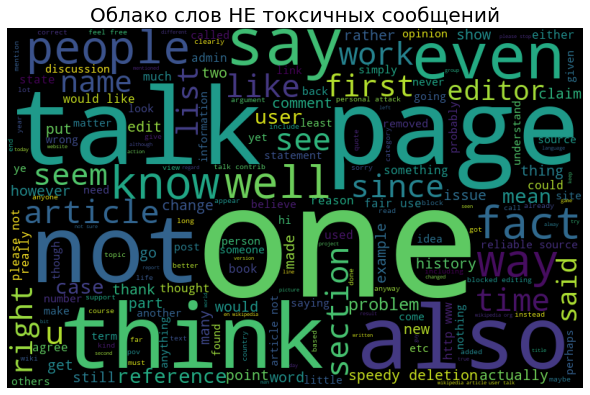

In [15]:
# визуализируем облако слов в текстах с не токсичной коннотацией 
words_list = data[data['toxic']==0]['text'].unique().tolist()
pos_words = " ".join(words_list)
 
pos_wordcloud =  WordCloud(
                  width=800, height = 500,            
                  stopwords=stop_words).generate(pos_words)
 
plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Облако слов НЕ токсичных сообщений', fontsize=20);

### Разделение на выборки и upsampling

In [16]:
# делим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(['toxic'], axis=1)
y = data['toxic']

In [17]:
# создаем обучающую и тестовую выборки
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify = y, random_state=0
)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119469, 1)
(39823, 1)
(119469,)
(39823,)


In [19]:
# создаем функцию upsampling чтобы сбалансировать классы путём увеличения числа
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled)
    return features_upsampled, target_upsampled

In [20]:
# применяем функцию к обучающей выборке
X_train, y_train = upsample(X_train, y_train, repeat=6)
print(X_train.shape)
print(y_train.shape)

(180169, 1)
(180169,)


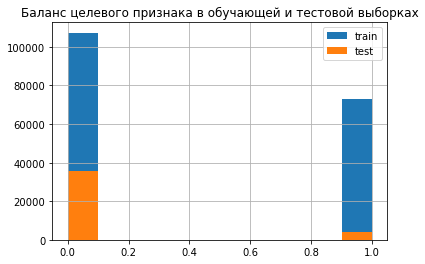

In [21]:
# проверяем баланс целевых переменных
y_train.hist(label='train')
y_test.hist(label='test')
plt.legend()
plt.title('Баланс целевого признака в обучающей и тестовой выборках');

In [22]:
# проверяем долю 1, миноритарного класса в обучающей выбоке
y_train.mean()

0.4042870860136871

**Выводы по данным и графику:**
* применение метода увеличения обучающей выборки позволило изменить баланс целевого признака с 9х1 на 6х4

### Выбор метода векторизации

In [23]:
# создаем переменные корпусов
corpus_train = X_train['text'].values
corpus_test = X_test['text'].values

**мешок слов**

In [46]:
%%time
# создаем мешок слов
count_vect_bow = CountVectorizer(dtype='float64') 
bow_train = count_vect_bow.fit_transform(corpus_train)
print("Размер мешка слов обучающая выборка:", bow_train.shape)

Размер мешка слов обучающая выборка: (180169, 143655)
Wall time: 21.8 s


In [25]:
# инициируем модель
model = LogisticRegression(random_state=0) 

In [26]:
# выводим метрику f1 по результатам кросс валидации
#scores = cross_val_score(model, bow_train, y_train, cv=5, scoring='f1_weighted')
#print('Взвешенная метрика F1 по результатам кросс-валидации, мешок слов:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, мешок слов: 0.9676

**триграммы**

In [27]:
%%time
# создаем триграммы
count_vect = CountVectorizer(ngram_range=(3, 3))
n_gramm_train = count_vect.fit_transform(corpus_train)
print("Размер триграммы train:", n_gramm_train.shape)

Размер триграммы train: (180169, 3314110)
Wall time: 1min 9s


In [28]:
# инициируем модель
model = LogisticRegression(random_state=0)

In [29]:
# выводим метрику f1 по результатам кросс валидации
#scores = cross_val_score(model, n_gramm_train, y_train, cv=5, scoring='f1_weighted') 
#print('Взвешенная метрика F1 по результатам кросс-валидации, триграммы:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, триграммы: 0.9821

**матрица tf_idf**

In [30]:
%%time
# считаем величину TF-IDF
count_tf_idf = TfidfVectorizer()
tf_idf_train = count_tf_idf.fit_transform(X_train.text)
display(tf_idf_train.shape)

(180169, 143655)

Wall time: 24.9 s


In [31]:
# инициируем модель
model = LogisticRegression(random_state=0)

In [32]:
# выводим метрику f1 по результатам кросс валидации
#scores = cross_val_score(model, tf_idf_train, y_train, cv=5, scoring='f1_weighted')
#print('Взвешенная метрика F1 по результатам кросс-валидации, tfidf:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, tfidf: 0.951

#### Выводы:

In [33]:
# строим сводную таблицу результатов векторизации разными методами
vectorizer_best = pd.DataFrame(columns=(['vectorizer', 'time_to_vectorize', 'shape_train', 'model', 'f1_weighted_cross_val_score']))
vectorizer_best.vectorizer = ['bag of words', 'three gramm', 'tf_idf']
vectorizer_best.time_to_vectorize = ['20.2 s', '1 min 15 s', '2 min 32 s']
vectorizer_best.shape_train = ['180 169 x 143 655', '180 169 x 3 314 110', '180 169 x 143 655']
vectorizer_best.model = ['LogisticRegression', 'LogisticRegression', 'LogisticRegression']
vectorizer_best.f1_weighted_cross_val_score = [0.9676, 0.9821, 0.951]

display(vectorizer_best.sort_values(by='f1_weighted_cross_val_score', ascending=False))

,vectorizer,time_to_vectorize,shape_train,model,f1_weighted_cross_val_score
1,three gramm,1 min 15 s,180 169 x 3 314 110,LogisticRegression,0.9821
0,bag of words,20.2 s,180 169 x 143 655,LogisticRegression,0.9676
2,tf_idf,2 min 32 s,180 169 x 143 655,LogisticRegression,0.9510


* для выбора метода векторизации была применена кросс валидация по модели логистической регрессии с параметрами по умолчанию к обучающим выборкам, векторизированным с помощью:
>
> мешка слов
>
> триграммы
>
> TF-IDF
>
* самый **высокий скор** средней взвешенной метрики F1 модель показала на **триграммах = 0.9821**, при этом метод порождает самую большую матрицу и требует самое длительное время векторизации
* **на втором месте** по показателю средней взвешенной метрики F1 оказалась модель, оцененная на **мешке слов = 0.9676**
* **на третьем месте** оказалась модель, векторизированная методом **TF-IDF = 0.951**
* не смотря на существенный отрыв по метрике метода триграмм, принято решение выбирать модель на основе выборки, векторизированной методом мешка слов, т.к. матрица, рожденная методом триграмм потребует больших ресурсов для обучения моделей

## Выбор модели

**LogisticRegression**

In [34]:
# инициируем модель LogisticRegression c гиперпараметром solver = 'liblinear'
lr_model = LogisticRegression(random_state = 0, solver = 'liblinear')

In [35]:
# выводим взвешенную метрику f1 по результатам кросс-валидации
#scores = cross_val_score(lr_model, bow_train, y_train, cv=5, scoring='f1_weighted')
#print('Взвешенная метрика F1 по результатам кросс-валидации, логистическая регрессия:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, логистическая регрессия: 0.9447

**RandomForestClassifier**

In [36]:
# подбираем лучшие гиперпараметры  n_estimators, max_depth, min_samples_leaf с RandomizedSearchCV,
# выбираем метрику настройки F1
#n_estimators = range(1, 100)
#max_depth = range(1,50)
#min_samples_leaf = range(1,13)   

#hyperparameters = dict( max_depth=max_depth, min_samples_leaf = min_samples_leaf, n_estimators = n_estimators)
#RandomForest = RandomForestClassifier(random_state = 0)

#randomizedsearch = RandomizedSearchCV(RandomForest, hyperparameters, random_state = 0, scoring='f1', cv=3, n_iter=5) 
#randomforest = randomizedsearch.fit(bow_train, y_train)
#print(randomforest.best_estimator_)

* RandomForestClassifier(max_depth=45, min_samples_leaf=2, n_estimators=46, random_state=0)

In [37]:
# инициируем модель RandomForestClassifier c лучшими гиперпараметрами
rf_model = RandomForestClassifier(max_depth=45, min_samples_leaf=2, n_estimators=46, random_state=0)

In [38]:
# выводим метрику f1 по результатам кросс-валидации
#scores = cross_val_score(rf_model, bow_train, y_train, cv=5, scoring='f1_weighted')
#print('Взвешенная метрика F1 по результатам кросс-валидации, случайный лес:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, случайный лес: 0.7896

**LGBM**

In [39]:
# инициируем модель LGBMClassifier со скоростью обучения 0.4, максимальной глубиной = 4 и кол-вом листьев = 15
lgbm_model = LGBMClassifier(random_state = 0, learning_rate = 0.4, max_depth = 4, num_leaves = 15)

In [40]:
# выводим метрику f1 по результатам кросс-валидации
#scores = cross_val_score(lgbm_model, bow_train, y_train, cv=5, scoring='f1_weighted')
#print('Взвешенная метрика F1 по результатам кросс-валидации, LGBM:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, LGBM: 0.8948

**CatBoostClassifier**

In [41]:
# инициируем модель CatBoostClassifier, настроенную на метрику F1, с кол-вом итераций = 100
catboost_model = CatBoostClassifier(eval_metric = 'F1', random_state=0, iterations=100)

In [42]:
# выводим метрику f1 по результатам кросс-валидации
#scores = cross_val_score(catboost_model, bow_train, y_train, cv=5, scoring='f1_weighted')
#print('Взвешенная метрика F1 по результатам кросс-валидации, CatBoost:', scores.mean().round(4))

* Взвешенная метрика F1 по результатам кросс-валидации, CatBoost: 0.9093

### Выводы
* лучший показатель взвешенной метрики F1 по результатам кросс-валидации с 5 фолдами на выборке, векторизированной с помощью мешка слов, удалось достичь модели логистической регрессии:
1. LogisticRegression (solver='liblinear') = 0.9447
2. CatBoostClassifier (eval_metric = 'F1', iterations=100) = 0.9093
3. LGBMClassifier (learning_rate = 0.4, max_depth = 4, num_leaves = 15) = 0.8948
4. RandomForestClassifier (max_depth=45, min_samples_leaf=2, n_estimators=46) = 0.7896
* принято решение использовать для пердсказаний на тестовой выборке модель Логистической Регрессии

## Обучение и предсказание

In [47]:
# векторизируем тестовую выборку мешком слов
bow_test = count_vect_bow.transform(corpus_test)
print("Размер мешка слов тестовая выборка:", bow_test.shape)

Размер мешка слов тестовая выборка: (39823, 143655)


In [48]:
# обучаем модель Логистической Регрессии
lr_model.fit(bow_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [49]:
# делаем предсказание на тестовой выборке,
# выводим метрику F1
lr_pred = lr_model.predict(bow_test)
print('Метрика F1 на тестовой выборке с моделью Логистической Регрессии:', f1_score(y_test, lr_pred).round(4))

Метрика F1 на тестовой выборке с моделью Логистической Регрессии: 0.7577


## Выводы

* в проекте были проверены 4 метода векторизации и был выбран подход расчета "мешок слов", который на наивной модели Логистической Регрессии показал приближенный к лучшему результат предсказаний по метрике F1 и при этом оказался самым быстрым
* для определения лучшей модели были проверены:
>
> **LogisticRegression** - в модели применен гиперпараметр solver - 'liblinear'
>
> **RandomForestClassifier** - для определения лучших гиперпараметров, настроенных на метрику F1, применен RandomizedSearchCV, предложивший значения: max_depth=45, min_samples_leaf=2, n_estimators=46
>
> **LGBMClassifier** - в связи со слабыми вычислетельными мощностями для определения лучших гиперпараметров не применен RandomizedSearchCV и использованы усеченные относительно исходных гиперпараметры, влияющие на скоорость: learning_rate = 0.4, max_depth = 4, num_leaves = 15
>
> **CatBoostClassifier** - в связи со слабыми вычислетельными мощностями для определения лучших гиперпараметров не применен RandomizedSearchCV и использованы усеченные относительно исходных гиперпараметры, влияющие на скоорость: iterations=100
>
* по результатам оценки взвешенной метрики F1 на 5 фолдах кросс-валидаций **победила модель Логистической Регрессии**
* по результатам обучения и предсказания на тестовой выборке победившая модель логистической Регрессии достигла ожидаемого в данном проекте скора F1 = 0.7577 (выше, чем 0.75)
* в зависимости от вычислительных возможностей клиенту рекомендуется:
>
> в случае ограничейний - использовать для решения задачи модель Логистической регрессии
>
> в случае отсутствия ограничений - взять за базу результат модели CatBoostClassifier, полученный в данном проекте, и проверить возможность его улучшения за счет более тонкого подбора гиперпараметров